In [25]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, BatchNormalization, Activation, add, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
import random
import time
import importlib

from tqdm.notebook import tqdm

from settings import ROWS, COLUMNS, PLAYER, AI, EMPTY
from board import is_valid_location, get_next_open_row, get_valid_locations, create_board, drop_piece, winning_move
import MCTS
importlib.reload(MCTS)
from MCTS import mcts_search

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [27]:
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Đang sử dụng GPU")
    tf.config.run_functions_eagerly(True)
except:
    print("Không tìm thấy GPU, sử dụng CPU")
    tf.config.run_functions_eagerly(True)

In [40]:
class Connect4NeuralNetwork:
    def __init__(self, model_path=None):
        self.model = None
        self.model_path = model_path
        self._prediction_cache = {}
        self.model_ready = False
        
        if model_path and os.path.exists(model_path):
            self.load_model(model_path)
        else:
            self.build_model()
    
    def build_model(self):
        input_shape = (ROWS, COLUMNS, 3)
        inputs = Input(shape=input_shape)
        
        x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.00015))(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
   
        x = self._residual_block(x, 64)
        x = self._residual_block(x, 64)
        x = self._residual_block(x, 64)
        x = Dropout(0.15)(x)
        x = self._residual_block(x, 128)
        x = Dropout(0.15)(x)
        x = self._residual_block(x, 128)

        policy_head = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(x)
        policy_head = BatchNormalization()(policy_head)
        policy_head = Activation('relu')(policy_head)
        policy_head = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(policy_head)
        policy_head = BatchNormalization()(policy_head)
        policy_head = Activation('relu')(policy_head)
        policy_head = Flatten()(policy_head)
        policy_head = Dropout(0.275)(policy_head)
        policy_head = Dense(COLUMNS, activation='softmax', name='policy', kernel_regularizer=l2(0.00015))(policy_head)
        
        value_head = Conv2D(64, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(x)
        value_head = BatchNormalization()(value_head)
        value_head = Activation('relu')(value_head)
        value_head = Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(0.00015))(value_head)
        value_head = BatchNormalization()(value_head)
        value_head = Activation('relu')(value_head)
        value_head = Flatten()(value_head)
        value_head = Dense(64, activation='relu', kernel_regularizer=l2(0.0002))(value_head)
        value_head = Dropout(0.5)(value_head)
        value_head = Dense(32, activation='relu', kernel_regularizer=l2(0.0002))(value_head)
        value_head = Dropout(0.3)(value_head)
        value_head = Dense(1, activation='tanh', name='value', kernel_regularizer=l2(0.0002))(value_head)
        
        self.model = Model(inputs=inputs, outputs=[policy_head, value_head])
        
        self.model.compile(
            optimizer=Adam(learning_rate=0.00005),
            loss={
                'policy': 'categorical_crossentropy',
                'value': 'mean_squared_error'
            },
            loss_weights={
                'policy': 1.2,
                'value': 2.5
            },
            metrics={
                'policy': 'accuracy',
                'value': 'mean_absolute_error'
            }
        )
        
        self.model.summary()
        self.model_ready = True
    
    # Học phần chênh lệch
    def _residual_block(self, x, filters):
        shortcut = x
        
        # x = Conv2D(filters, (3, 3), padding='same')(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(0.00015))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # x = Conv2D(filters, (3, 3), padding='same')(x)
        x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(0.00015))(x)
        x = BatchNormalization()(x)
        
        x = add([x, shortcut])
        x = Activation('relu')(x)
        
        return x
    
    def _board_to_key(self, board):
        key = []
        for r in range(ROWS):
            for c in range(COLUMNS):
                key.append(str(board[r][c]))
        return "".join(key)
    
    def _board_to_tensor(self, board):
        tensor = np.zeros((ROWS, COLUMNS, 3), dtype=np.float32)
        
        for r in range(ROWS):
            for c in range(COLUMNS):
                if board[r][c] == AI:
                    tensor[r, c, 0] = 1
                elif board[r][c] == PLAYER:
                    tensor[r, c, 1] = 1
                else:  # EMPTY
                    tensor[r, c, 2] = 1
        
        return tensor
    
    def predict(self, board):
        if not self.model_ready:
            default_policy = np.ones(COLUMNS) / COLUMNS
            default_value = 0.0
            return default_policy, default_value
        
        board_key = self._board_to_key(board)
        
        if board_key in self._prediction_cache:
            return self._prediction_cache[board_key]
        
        board_tensor = self._board_to_tensor(board)
        policy, value = self.model.predict(np.expand_dims(board_tensor, axis=0), verbose=0)

        result = (policy[0], value[0][0])
        
        self._prediction_cache[board_key] = result
        
        return result
    
    def clear_cache(self):
        self._prediction_cache = {}
    
    def train(self, boards, policies, values, epochs=15, batch_size=64, validation_split=0.2):
        X = np.array([self._board_to_tensor(board) for board in boards])
        y_policy = np.array(policies, dtype=np.float32)
        y_value = np.array(values, dtype=np.float32).reshape(-1, 1)
        
        callbacks = [
            ModelCheckpoint(
                filepath='models/best_connect4_model.h5',
                save_best_only=True,
                monitor='val_loss',
                mode='min'
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=12,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.6,
                patience=3,
                min_lr=0.000008
            )
        ]
        
        history = self.model.fit(
            X, 
            {'policy': y_policy, 'value': y_value},
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1
        )
        
        self.clear_cache()
        
        return history
    
    def save_model(self, path='models/connect4_model.h5'):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        self.model.save(path)
        print(f"Model đã được lưu tại {path}")
    
    def load_model(self, path):
        self.model = tf.keras.models.load_model(path)
        print(f"Model đã được tải từ {path}")
        self.model_ready = True

        self.model.compile(
        optimizer=Adam(learning_rate=0.00005), 
        loss={
            'policy': 'categorical_crossentropy',
            'value': 'mean_squared_error'
        },
        loss_weights={
        'policy': 1.3,
        'value': 2.4
        },
        metrics={
            'policy': 'accuracy',
            'value': 'mean_absolute_error'
        }
    )
    
    def generate_training_data(self, mcts_games, augment=True):
        boards = []
        policies = []
        values = []
        
        for board, policy, result in mcts_games:
            boards.append(board)
            policies.append(policy)
            values.append(result)
  
            if augment:
                flipped_board = np.flip(board, axis=1).copy()
                flipped_policy = np.flip(policy).copy()
                boards.append(flipped_board)
                policies.append(flipped_policy)
                values.append(result)
                
                # Thêm nhiễu nhẹ vào policy để tăng tính đa dạng
                if len(policy) > 0:
                    noisy_policy = policy.copy()
                    noise = np.random.normal(0, 0.025, size=policy.shape)
                    for i in range(len(policy)):
                        if policy[i] > 0.03: 
                            noisy_policy[i] += noise[i]
                    noisy_policy = np.maximum(noisy_policy, 0)
                    if np.sum(noisy_policy) > 0:
                        noisy_policy /= np.sum(noisy_policy)
                        boards.append(board)
                        policies.append(noisy_policy)
                        values.append(result)
        
        return boards, policies, values

In [41]:
class Connect4Agent:
    def __init__(self, neural_network=None, model_path=None):

        if neural_network:
            self.nn = neural_network
        else:
            self.nn = Connect4NeuralNetwork(model_path)
        
        self.temperature = 1.0  
        self.batch_size = 32  
    
    def fast_mcts(self, board, num_simulations=2000, temperature_decay=True):
        pieces_count = np.count_nonzero(board != EMPTY)
        total_positions = ROWS * COLUMNS
        game_progress = pieces_count / total_positions  # 0.0 đến 1.0

        if temperature_decay:
            temperature = max(0.2, 1.0 - game_progress * 0.6)
        else:
            temperature = 1.0

        # Điều chỉnh PUCT dựa trên số mô phỏng
        puct_coefficient = 2.0 if num_simulations <= 300 else 1.0
    
        # Chạy MCTS với điều chỉnh PUCT
        move, mcts_policy = mcts_search(board, AI, self.nn, num_simulations, puct_coefficient=puct_coefficient)
    
        if temperature != 1.0:
            mcts_policy = np.power(mcts_policy + 1e-10, 1.0/temperature)
            mcts_policy /= np.sum(mcts_policy)
    
        return move, mcts_policy

In [60]:
import ai
importlib.reload(ai)
from ai import minimax
from settings import AI_DIFFICULTY
import math

In [61]:
def collect_self_play_data(agent, num_games=50, mcts_simulations=2000):
    training_data = []
    win_stats = {'AI': 0, 'PLAYER': 0, 'DRAW': 0}
    
    for game_idx in tqdm(range(num_games), desc="Self-play games"):
        board = create_board()
        game_memory = []
        current_player = AI if game_idx % 2 == 0 else PLAYER  # Luân phiên người đi trước
        
        game_start_time = time.time()
        
        while True:
            valid_moves = get_valid_locations(board)
            
            if not valid_moves:  
                result = 0.0
                win_stats['DRAW'] += 1
                break
                
            if current_player == AI:
                move, mcts_policy = agent.fast_mcts(board, mcts_simulations, temperature_decay=True)
                game_memory.append((board.copy(), mcts_policy, AI))
            else:
                move, minimax_policy = minimax(board, AI_DIFFICULTY, -math.inf, math.inf, True)
                # move, mcts_policy = mcts_search(board, AI, neural_network=None)
                game_memory.append((board.copy(), minimax_policy, PLAYER))
            
            row = get_next_open_row(board, move)
            drop_piece(board, row, move, current_player)
            
            if winning_move(board, current_player)[0]:
                if current_player == AI:
                    result = 1.0
                    win_stats['AI'] += 1
                else:
                    result = -1.0
                    win_stats['PLAYER'] += 1
                break
                
            current_player = PLAYER if current_player == AI else AI
        
        for board_state, policy, player in game_memory:
            if player == AI:
                training_data.append((board_state, policy, result))
            else:
                training_data.append((board_state, policy, -result))
        
        game_time = time.time() - game_start_time
        print(f"Game {game_idx+1} hoàn thành trong {game_time:.1f}s: {'AI' if result > 0 else 'PLAYER' if result < 0 else 'HOÀ'}")
        
        if (game_idx + 1) % 5 == 0:
            print(f"Thống kê sau {game_idx + 1} trò chơi:")
            print(f"NN thắng: {win_stats['AI']} ({win_stats['AI']/(game_idx+1)*100:.1f}%)")
            print(f"Minimax thắng: {win_stats['PLAYER']} ({win_stats['PLAYER']/(game_idx+1)*100:.1f}%)")
            print(f"Hoà: {win_stats['DRAW']} ({win_stats['DRAW']/(game_idx+1)*100:.1f}%)")
    
    print(f"Thống kê cuối cùng - NN thắng: {win_stats['AI']}, Minimax thắng: {win_stats['PLAYER']}, Hoà: {win_stats['DRAW']}")
    return training_data

In [62]:
def train_model_cycle(cycles=5, games_per_cycle=50, epochs_per_cycle=15, mcts_simulations=2000):
    model_path = 'models/connect4_model.h5' if os.path.exists('models/connect4_model.h5') else None
    nn = Connect4NeuralNetwork(model_path)
    agent = Connect4Agent(nn)
    
    training_history = []
    
    for cycle in range(cycles):
        cycle_start_time = time.time()
        print(f"=== Bắt đầu chu kỳ {cycle + 1}/{cycles} ===")
        
        # Thu thập dữ liệu từ tự chơi
        print("Thu thập dữ liệu tự chơi...")
        training_data = collect_self_play_data(agent, num_games=games_per_cycle, mcts_simulations=mcts_simulations)
        
        # Chuẩn bị dữ liệu huấn luyện
        boards, policies, values = nn.generate_training_data(training_data)
        
        print(f"Dữ liệu thu thập: {len(boards)} vị trí")
        
        print("Huấn luyện neural network...")
        history = nn.train(boards, policies, values, epochs=epochs_per_cycle, batch_size=32)
        training_history.append(history)
        
        nn.save_model(f'models/connect4_model_cycle_{cycle + 1}.h5')
        nn.save_model('models/connect4_model.h5') 
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['policy_accuracy'])
        plt.plot(history.history['val_policy_accuracy'])
        plt.title('Policy Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['value_mean_absolute_error'])
        plt.plot(history.history['val_value_mean_absolute_error'])
        plt.title('Value MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.tight_layout()
        plt.savefig(f'models/training_cycle_{cycle + 1}.png')
        plt.show()
        
        cycle_time = time.time() - cycle_start_time
        print(f"Chu kỳ {cycle + 1} hoàn thành trong {cycle_time/60:.2f} phút")
    
    return nn, training_history

In [8]:
import pygame as pg
import sys
from time import sleep
import random as rd

from settings import *

from importlib import reload
import utils
reload(utils)
from utils import create_gradient_background, draw_board, animate_piece_drop, show_game_over

In [19]:
def evaluate_model(agent, num_games=20, opponent='mcts'):
    win_stats = {'Agent': 0, 'Opponent': 0, 'Draw': 0}
    
    for game_idx in tqdm(range(num_games), desc="Evaluation games"):
        board = create_board()

        agent_first = game_idx % 2 == 0
        current_player = AI if agent_first else PLAYER
        
        while True:
            valid_moves = get_valid_locations(board)
            
            if not valid_moves: 
                win_stats['Draw'] += 1
                break
                
            if (current_player == AI and agent_first) or (current_player == PLAYER and not agent_first):
                if opponent == 'mcts':
                    move, _ = mcts_search(board, AI, neural_network=None)
                else:
                    move = random.choice(valid_moves)
            else:
                move, _ = agent.fast_mcts(board, 300, temperature_decay=False)
            
            row = get_next_open_row(board, move)
            drop_piece(board, row, move, current_player)
            
            if winning_move(board, current_player)[0]:
                if (current_player == AI and agent_first) or (current_player == PLAYER and not agent_first):
                    win_stats['Opponent'] += 1
                else:
                    win_stats['Agent'] += 1
                break
                
            current_player = PLAYER if current_player == AI else AI
    
    print(f"Kết quả đánh giá với {opponent}:")
    print(f"Agent thắng: {win_stats['Agent']} ({win_stats['Agent']/num_games*100:.1f}%)")
    print(f"Opponent thắng: {win_stats['Opponent']} ({win_stats['Opponent']/num_games*100:.1f}%)")
    print(f"Hoà: {win_stats['Draw']} ({win_stats['Draw']/num_games*100:.1f}%)")
    
    return win_stats


Model đã được tải từ models/connect4_model.h5
=== Bắt đầu chu kỳ 1/3 ===
Thu thập dữ liệu tự chơi...


Self-play games:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/trananhtuan/Library/Python/3.9/lib/python/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


MCTS: 2000 mô phỏng trong 39.079s
  Cột 4: 394 lần thăm, tỷ lệ thắng: 0.360
  Cột 3: 382 lần thăm, tỷ lệ thắng: 0.324
  Cột 0: 309 lần thăm, tỷ lệ thắng: 0.402
  Cột 2: 274 lần thăm, tỷ lệ thắng: 0.325
  Cột 1: 260 lần thăm, tỷ lệ thắng: 0.348
  Cột 6: 210 lần thăm, tỷ lệ thắng: 0.354
  Cột 5: 171 lần thăm, tỷ lệ thắng: 0.292
MCTS: 2000 mô phỏng trong 41.028s
  Cột 3: 905 lần thăm, tỷ lệ thắng: 0.453
  Cột 2: 238 lần thăm, tỷ lệ thắng: 0.362
  Cột 4: 232 lần thăm, tỷ lệ thắng: 0.360
  Cột 5: 198 lần thăm, tỷ lệ thắng: 0.370
  Cột 6: 175 lần thăm, tỷ lệ thắng: 0.388
  Cột 0: 134 lần thăm, tỷ lệ thắng: 0.350
  Cột 1: 118 lần thăm, tỷ lệ thắng: 0.287
MCTS: 2000 mô phỏng trong 35.383s
  Cột 6: 1191 lần thăm, tỷ lệ thắng: 0.620
  Cột 2: 184 lần thăm, tỷ lệ thắng: 0.372
  Cột 5: 136 lần thăm, tỷ lệ thắng: 0.357
  Cột 1: 128 lần thăm, tỷ lệ thắng: 0.347
  Cột 0: 127 lần thăm, tỷ lệ thắng: 0.382
  Cột 4: 121 lần thăm, tỷ lệ thắng: 0.307
  Cột 3: 113 lần thăm, tỷ lệ thắng: 0.256
MCTS: 2000 mô p

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 4.7555 - policy_accuracy: 0.3847 - policy_loss: 1.9559 - value_loss: 0.9220 - value_mean_absolute_error: 0.8484 - val_loss: 5.1624 - val_policy_accuracy: 0.3958 - val_policy_loss: 1.8596 - val_value_loss: 1.1437 - val_value_mean_absolute_error: 0.9609 - learning_rate: 5.0000e-05
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 4.0532 - policy_accuracy: 0.4419 - policy_loss: 1.7324 - value_loss: 0.7505 - value_mean_absolute_error: 0.7610

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 4.0529 - policy_accuracy: 0.4419 - policy_loss: 1.7323 - value_loss: 0.7504 - value_mean_absolute_error: 0.7609 - val_loss: 5.1181 - val_policy_accuracy: 0.4128 - val_policy_loss: 1.7976 - val_value_loss: 1.1589 - val_value_mean_absolute_error: 0.9320 - learning_rate: 5.0000e-05
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.8871 - policy_accuracy: 0.4910 - policy_loss: 1.6698 - value_loss: 0.7151 - value_mean_absolute_error: 0.7220

96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 3.8866 - policy_accuracy: 0.4910 - policy_loss: 1.6698 - value_loss: 0.7150 - value_mean_absolute_error: 0.7219 - val_loss: 5.0728 - val_policy_accuracy: 0.4141 - val_policy_loss: 1.7672 - val_value_loss: 1.1564 - val_value_mean_absolute_error: 0.9222 - learning_rate: 5.0000e-05
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 3.7400 - policy_accuracy: 0.4951 - policy_loss: 1.6424 - value_loss: 0.6687 - value_mean_absolute_error: 0.6929 - val_loss: 5.1988 - val_policy_accuracy: 0.4310 - val_policy_loss: 1.7467 - val_value_loss: 1.2200 - val_value_mean_absolute_error: 0.9493 - learning_rate: 5.0000e-05
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 3.6964 - policy_accuracy: 0.5250 - policy_loss: 1.6149 - value_loss: 0.6654 - value_mean_absolute_error: 0.6949 - val_loss: 5.2113 - val_policy_accuracy: 0.4505 - val_policy_loss: 1.7340 - val_value_loss: 1.2321 - val_value_mean_absolute_error: 0.9413 - learning_rate: 5.000

Model đã được lưu tại models/connect4_model_cycle_1.h5
Model đã được lưu tại models/connect4_model.h5


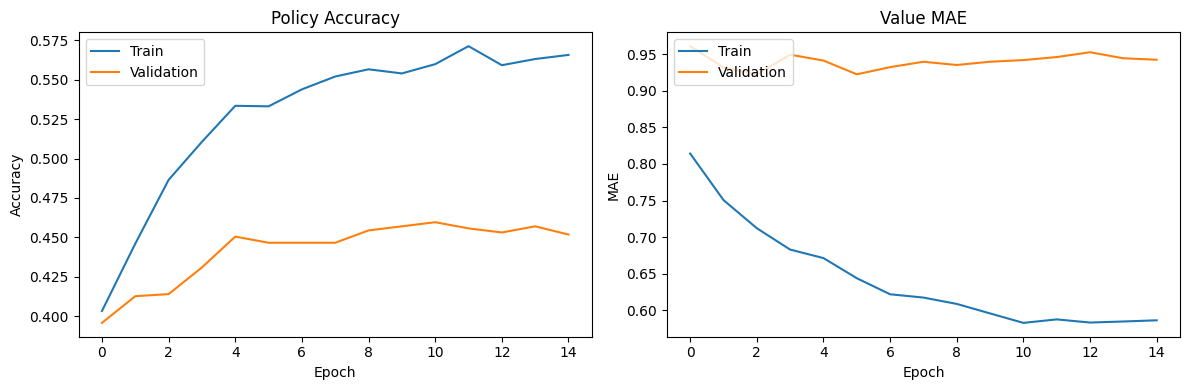

Chu kỳ 1 hoàn thành trong 118.50 phút
=== Bắt đầu chu kỳ 2/3 ===
Thu thập dữ liệu tự chơi...


Self-play games:   0%|          | 0/50 [00:00<?, ?it/s]

MCTS: 2000 mô phỏng trong 39.016s
  Cột 4: 623 lần thăm, tỷ lệ thắng: 0.379
  Cột 3: 260 lần thăm, tỷ lệ thắng: 0.261
  Cột 0: 245 lần thăm, tỷ lệ thắng: 0.352
  Cột 6: 226 lần thăm, tỷ lệ thắng: 0.343
  Cột 5: 218 lần thăm, tỷ lệ thắng: 0.305
  Cột 2: 216 lần thăm, tỷ lệ thắng: 0.270
  Cột 1: 212 lần thăm, tỷ lệ thắng: 0.301
MCTS: 2000 mô phỏng trong 32.745s
  Cột 5: 385 lần thăm, tỷ lệ thắng: 0.369
  Cột 4: 349 lần thăm, tỷ lệ thắng: 0.327
  Cột 3: 327 lần thăm, tỷ lệ thắng: 0.290
  Cột 6: 316 lần thăm, tỷ lệ thắng: 0.383
  Cột 2: 225 lần thăm, tỷ lệ thắng: 0.274
  Cột 0: 200 lần thăm, tỷ lệ thắng: 0.326
  Cột 1: 198 lần thăm, tỷ lệ thắng: 0.292
MCTS: 2000 mô phỏng trong 34.246s
  Cột 4: 427 lần thăm, tỷ lệ thắng: 0.287
  Cột 2: 348 lần thăm, tỷ lệ thắng: 0.266
  Cột 5: 331 lần thăm, tỷ lệ thắng: 0.294
  Cột 6: 260 lần thăm, tỷ lệ thắng: 0.299
  Cột 1: 242 lần thăm, tỷ lệ thắng: 0.256
  Cột 3: 206 lần thăm, tỷ lệ thắng: 0.168
  Cột 0: 186 lần thăm, tỷ lệ thắng: 0.256
MCTS: 2000 mô ph

104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 4.8556 - policy_accuracy: 0.4154 - policy_loss: 1.7156 - value_loss: 1.0939 - value_mean_absolute_error: 0.8952 - val_loss: 5.2413 - val_policy_accuracy: 0.4505 - val_policy_loss: 1.7257 - val_value_loss: 1.2491 - val_value_mean_absolute_error: 0.9738 - learning_rate: 8.0000e-06
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.5962 - policy_accuracy: 0.4228 - policy_loss: 1.6829 - value_loss: 1.0035 - value_mean_absolute_error: 0.8615

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 4.5965 - policy_accuracy: 0.4227 - policy_loss: 1.6831 - value_loss: 1.0035 - value_mean_absolute_error: 0.8615 - val_loss: 5.1524 - val_policy_accuracy: 0.4444 - val_policy_loss: 1.7139 - val_value_loss: 1.2185 - val_value_mean_absolute_error: 0.9783 - learning_rate: 8.0000e-06
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.5620 - policy_accuracy: 0.4160 - policy_loss: 1.6760 - value_loss: 0.9930 - value_mean_absolute_error: 0.8679

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 4.5618 - policy_accuracy: 0.4160 - policy_loss: 1.6760 - value_loss: 0.9929 - value_mean_absolute_error: 0.8679 - val_loss: 5.0405 - val_policy_accuracy: 0.4565 - val_policy_loss: 1.7040 - val_value_loss: 1.1772 - val_value_mean_absolute_error: 0.9734 - learning_rate: 8.0000e-06
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.4519 - policy_accuracy: 0.4380 - policy_loss: 1.6636 - value_loss: 0.9538 - value_mean_absolute_error: 0.8590

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 4.4518 - policy_accuracy: 0.4378 - policy_loss: 1.6637 - value_loss: 0.9538 - value_mean_absolute_error: 0.8591 - val_loss: 4.9102 - val_policy_accuracy: 0.4626 - val_policy_loss: 1.6963 - val_value_loss: 1.1271 - val_value_mean_absolute_error: 0.9631 - learning_rate: 8.0000e-06
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.2992 - policy_accuracy: 0.4325 - policy_loss: 1.6461 - value_loss: 0.8997 - value_mean_absolute_error: 0.8443

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 4.2993 - policy_accuracy: 0.4325 - policy_loss: 1.6462 - value_loss: 0.8997 - value_mean_absolute_error: 0.8443 - val_loss: 4.7890 - val_policy_accuracy: 0.4638 - val_policy_loss: 1.6896 - val_value_loss: 1.0802 - val_value_mean_absolute_error: 0.9514 - learning_rate: 8.0000e-06
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 4.2732 - policy_accuracy: 0.4299 - policy_loss: 1.6656 - value_loss: 0.8783 - value_mean_absolute_error: 0.8385

104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 4.2728 - policy_accuracy: 0.4299 - policy_loss: 1.6654 - value_loss: 0.8782 - value_mean_absolute_error: 0.8385 - val_loss: 4.6271 - val_policy_accuracy: 0.4601 - val_policy_loss: 1.6839 - val_value_loss: 1.0158 - val_value_mean_absolute_error: 0.9310 - learning_rate: 8.0000e-06
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.1715 - policy_accuracy: 0.4328 - policy_loss: 1.6366 - value_loss: 0.8516 - value_mean_absolute_error: 0.8371

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 4.1715 - policy_accuracy: 0.4329 - policy_loss: 1.6366 - value_loss: 0.8516 - value_mean_absolute_error: 0.8371 - val_loss: 4.5282 - val_policy_accuracy: 0.4577 - val_policy_loss: 1.6786 - val_value_loss: 0.9775 - val_value_mean_absolute_error: 0.9224 - learning_rate: 8.0000e-06
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.0448 - policy_accuracy: 0.4415 - policy_loss: 1.6127 - value_loss: 0.8118 - value_mean_absolute_error: 0.8177

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 4.0452 - policy_accuracy: 0.4415 - policy_loss: 1.6128 - value_loss: 0.8119 - value_mean_absolute_error: 0.8178 - val_loss: 4.4060 - val_policy_accuracy: 0.4698 - val_policy_loss: 1.6734 - val_value_loss: 0.9294 - val_value_mean_absolute_error: 0.9040 - learning_rate: 8.0000e-06
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.0056 - policy_accuracy: 0.4688 - policy_loss: 1.6124 - value_loss: 0.7956 - value_mean_absolute_error: 0.8135

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 4.0059 - policy_accuracy: 0.4687 - policy_loss: 1.6124 - value_loss: 0.7957 - value_mean_absolute_error: 0.8135 - val_loss: 4.3594 - val_policy_accuracy: 0.4698 - val_policy_loss: 1.6690 - val_value_loss: 0.9124 - val_value_mean_absolute_error: 0.8976 - learning_rate: 8.0000e-06
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.9845 - policy_accuracy: 0.4628 - policy_loss: 1.6053 - value_loss: 0.7907 - value_mean_absolute_error: 0.8124

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.9846 - policy_accuracy: 0.4628 - policy_loss: 1.6054 - value_loss: 0.7907 - value_mean_absolute_error: 0.8124 - val_loss: 4.2936 - val_policy_accuracy: 0.4771 - val_policy_loss: 1.6651 - val_value_loss: 0.8871 - val_value_mean_absolute_error: 0.8865 - learning_rate: 8.0000e-06
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.9478 - policy_accuracy: 0.4600 - policy_loss: 1.6021 - value_loss: 0.7771 - value_mean_absolute_error: 0.8049

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.9481 - policy_accuracy: 0.4601 - policy_loss: 1.6021 - value_loss: 0.7772 - value_mean_absolute_error: 0.8049 - val_loss: 4.2743 - val_policy_accuracy: 0.4819 - val_policy_loss: 1.6613 - val_value_loss: 0.8811 - val_value_mean_absolute_error: 0.8851 - learning_rate: 8.0000e-06
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.9567 - policy_accuracy: 0.4665 - policy_loss: 1.6140 - value_loss: 0.7744 - value_mean_absolute_error: 0.8019

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.9567 - policy_accuracy: 0.4665 - policy_loss: 1.6139 - value_loss: 0.7744 - value_mean_absolute_error: 0.8019 - val_loss: 4.2437 - val_policy_accuracy: 0.4831 - val_policy_loss: 1.6578 - val_value_loss: 0.8702 - val_value_mean_absolute_error: 0.8800 - learning_rate: 8.0000e-06
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.9671 - policy_accuracy: 0.4687 - policy_loss: 1.5951 - value_loss: 0.7890 - value_mean_absolute_error: 0.8115

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 3.9668 - policy_accuracy: 0.4688 - policy_loss: 1.5951 - value_loss: 0.7888 - value_mean_absolute_error: 0.8114 - val_loss: 4.2127 - val_policy_accuracy: 0.4819 - val_policy_loss: 1.6547 - val_value_loss: 0.8590 - val_value_mean_absolute_error: 0.8742 - learning_rate: 8.0000e-06
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.9192 - policy_accuracy: 0.4778 - policy_loss: 1.5949 - value_loss: 0.7691 - value_mean_absolute_error: 0.8027

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.9190 - policy_accuracy: 0.4777 - policy_loss: 1.5948 - value_loss: 0.7691 - value_mean_absolute_error: 0.8027 - val_loss: 4.1963 - val_policy_accuracy: 0.4783 - val_policy_loss: 1.6518 - val_value_loss: 0.8537 - val_value_mean_absolute_error: 0.8699 - learning_rate: 8.0000e-06
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.8724 - policy_accuracy: 0.4858 - policy_loss: 1.5751 - value_loss: 0.7603 - value_mean_absolute_error: 0.7960

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.8724 - policy_accuracy: 0.4857 - policy_loss: 1.5752 - value_loss: 0.7603 - value_mean_absolute_error: 0.7959 - val_loss: 4.1637 - val_policy_accuracy: 0.4771 - val_policy_loss: 1.6488 - val_value_loss: 0.8418 - val_value_mean_absolute_error: 0.8645 - learning_rate: 8.0000e-06
Epoch 16/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.8438 - policy_accuracy: 0.4745 - policy_loss: 1.5791 - value_loss: 0.7462 - value_mean_absolute_error: 0.7864

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.8438 - policy_accuracy: 0.4744 - policy_loss: 1.5791 - value_loss: 0.7462 - value_mean_absolute_error: 0.7864 - val_loss: 4.1331 - val_policy_accuracy: 0.4771 - val_policy_loss: 1.6461 - val_value_loss: 0.8305 - val_value_mean_absolute_error: 0.8558 - learning_rate: 8.0000e-06
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 3.8511 - policy_accuracy: 0.4610 - policy_loss: 1.5908 - value_loss: 0.7429 - value_mean_absolute_error: 0.7838 - val_loss: 4.1353 - val_policy_accuracy: 0.4771 - val_policy_loss: 1.6433 - val_value_loss: 0.8329 - val_value_mean_absolute_error: 0.8573 - learning_rate: 8.0000e-06
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.7741 - policy_accuracy: 0.4781 - policy_loss: 1.5501 - value_loss: 0.7329 - value_mean_absolute_error: 0.7772 - val_loss: 4.1372 - val_policy_accuracy: 0.4734 - val_policy_loss: 1.6411 - val_value_loss: 0.8349 - val_value_mean_absolute_error: 0.8563 - learning_rat

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.7784 - policy_accuracy: 0.4784 - policy_loss: 1.5662 - value_loss: 0.7260 - value_mean_absolute_error: 0.7720 - val_loss: 4.1257 - val_policy_accuracy: 0.4674 - val_policy_loss: 1.6392 - val_value_loss: 0.8311 - val_value_mean_absolute_error: 0.8537 - learning_rate: 8.0000e-06
Epoch 20/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 3.8090 - policy_accuracy: 0.4678 - policy_loss: 1.5757 - value_loss: 0.7336 - value_mean_absolute_error: 0.7760

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 3.8090 - policy_accuracy: 0.4678 - policy_loss: 1.5756 - value_loss: 0.7336 - value_mean_absolute_error: 0.7760 - val_loss: 4.1038 - val_policy_accuracy: 0.4686 - val_policy_loss: 1.6371 - val_value_loss: 0.8232 - val_value_mean_absolute_error: 0.8483 - learning_rate: 8.0000e-06


Model đã được lưu tại models/connect4_model_cycle_2.h5
Model đã được lưu tại models/connect4_model.h5


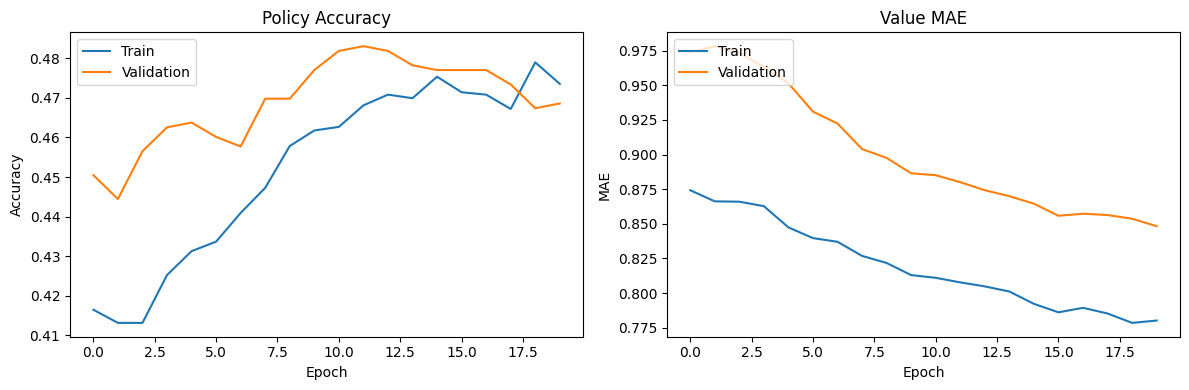

Chu kỳ 2 hoàn thành trong 116.52 phút
=== Bắt đầu chu kỳ 3/3 ===
Thu thập dữ liệu tự chơi...


Self-play games:   0%|          | 0/50 [00:00<?, ?it/s]

MCTS: 2000 mô phỏng trong 37.765s
  Cột 3: 715 lần thăm, tỷ lệ thắng: 0.304
  Cột 1: 251 lần thăm, tỷ lệ thắng: 0.268
  Cột 4: 250 lần thăm, tỷ lệ thắng: 0.233
  Cột 5: 224 lần thăm, tỷ lệ thắng: 0.253
  Cột 0: 200 lần thăm, tỷ lệ thắng: 0.270
  Cột 2: 191 lần thăm, tỷ lệ thắng: 0.197
  Cột 6: 169 lần thăm, tỷ lệ thắng: 0.247
MCTS: 2000 mô phỏng trong 34.637s
  Cột 2: 600 lần thăm, tỷ lệ thắng: 0.336
  Cột 4: 325 lần thăm, tỷ lệ thắng: 0.278
  Cột 3: 296 lần thăm, tỷ lệ thắng: 0.233
  Cột 5: 253 lần thăm, tỷ lệ thắng: 0.282
  Cột 0: 199 lần thăm, tỷ lệ thắng: 0.285
  Cột 1: 194 lần thăm, tỷ lệ thắng: 0.245
  Cột 6: 133 lần thăm, tỷ lệ thắng: 0.220
MCTS: 2000 mô phỏng trong 36.308s
  Cột 3: 816 lần thăm, tỷ lệ thắng: 0.370
  Cột 5: 251 lần thăm, tỷ lệ thắng: 0.317
  Cột 2: 208 lần thăm, tỷ lệ thắng: 0.258
  Cột 6: 207 lần thăm, tỷ lệ thắng: 0.325
  Cột 4: 204 lần thăm, tỷ lệ thắng: 0.256
  Cột 1: 199 lần thăm, tỷ lệ thắng: 0.288
  Cột 0: 115 lần thăm, tỷ lệ thắng: 0.230
MCTS: 2000 mô ph

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 4.7653 - policy_accuracy: 0.3388 - policy_loss: 1.7502 - value_loss: 1.0375 - value_mean_absolute_error: 0.9514 - val_loss: 4.1731 - val_policy_accuracy: 0.4066 - val_policy_loss: 1.6269 - val_value_loss: 0.8575 - val_value_mean_absolute_error: 0.8488 - learning_rate: 8.0000e-06
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.5837 - policy_accuracy: 0.3738 - policy_loss: 1.7278 - value_loss: 0.9740 - value_mean_absolute_error: 0.9324

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 4.5835 - policy_accuracy: 0.3739 - policy_loss: 1.7277 - value_loss: 0.9740 - value_mean_absolute_error: 0.9324 - val_loss: 4.0993 - val_policy_accuracy: 0.4078 - val_policy_loss: 1.6191 - val_value_loss: 0.8310 - val_value_mean_absolute_error: 0.8367 - learning_rate: 8.0000e-06
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 4.4883 - policy_accuracy: 0.3801 - policy_loss: 1.6986 - value_loss: 0.9501 - value_mean_absolute_error: 0.9205 - val_loss: 4.1016 - val_policy_accuracy: 0.4090 - val_policy_loss: 1.6138 - val_value_loss: 0.8348 - val_value_mean_absolute_error: 0.8405 - learning_rate: 8.0000e-06
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.4293 - policy_accuracy: 0.3935 - policy_loss: 1.6962 - value_loss: 0.9268 - value_mean_absolute_error: 0.9161

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.4294 - policy_accuracy: 0.3935 - policy_loss: 1.6962 - value_loss: 0.9268 - value_mean_absolute_error: 0.9161 - val_loss: 4.0836 - val_policy_accuracy: 0.4173 - val_policy_loss: 1.6095 - val_value_loss: 0.8297 - val_value_mean_absolute_error: 0.8377 - learning_rate: 8.0000e-06
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 4.4112 - policy_accuracy: 0.3872 - policy_loss: 1.6968 - value_loss: 0.9189 - value_mean_absolute_error: 0.9110

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 4.4112 - policy_accuracy: 0.3873 - policy_loss: 1.6968 - value_loss: 0.9189 - value_mean_absolute_error: 0.9110 - val_loss: 4.0566 - val_policy_accuracy: 0.4220 - val_policy_loss: 1.6059 - val_value_loss: 0.8204 - val_value_mean_absolute_error: 0.8333 - learning_rate: 8.0000e-06
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.4050 - policy_accuracy: 0.3965 - policy_loss: 1.6973 - value_loss: 0.9160 - value_mean_absolute_error: 0.9089

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.4048 - policy_accuracy: 0.3965 - policy_loss: 1.6972 - value_loss: 0.9160 - value_mean_absolute_error: 0.9089 - val_loss: 4.0317 - val_policy_accuracy: 0.4232 - val_policy_loss: 1.6027 - val_value_loss: 0.8117 - val_value_mean_absolute_error: 0.8290 - learning_rate: 8.0000e-06
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.3463 - policy_accuracy: 0.4074 - policy_loss: 1.6831 - value_loss: 0.8993 - value_mean_absolute_error: 0.9005

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.3462 - policy_accuracy: 0.4074 - policy_loss: 1.6831 - value_loss: 0.8993 - value_mean_absolute_error: 0.9005 - val_loss: 3.9974 - val_policy_accuracy: 0.4326 - val_policy_loss: 1.6002 - val_value_loss: 0.7988 - val_value_mean_absolute_error: 0.8216 - learning_rate: 8.0000e-06
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.3100 - policy_accuracy: 0.4037 - policy_loss: 1.6773 - value_loss: 0.8873 - value_mean_absolute_error: 0.8937 - val_loss: 3.9989 - val_policy_accuracy: 0.4303 - val_policy_loss: 1.5979 - val_value_loss: 0.8007 - val_value_mean_absolute_error: 0.8226 - learning_rate: 8.0000e-06
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.2719 - policy_accuracy: 0.4228 - policy_loss: 1.6691 - value_loss: 0.8759 - value_mean_absolute_error: 0.8887

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.2721 - policy_accuracy: 0.4227 - policy_loss: 1.6691 - value_loss: 0.8759 - value_mean_absolute_error: 0.8887 - val_loss: 3.9766 - val_policy_accuracy: 0.4279 - val_policy_loss: 1.5958 - val_value_loss: 0.7925 - val_value_mean_absolute_error: 0.8175 - learning_rate: 8.0000e-06
Epoch 10/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.2535 - policy_accuracy: 0.4231 - policy_loss: 1.6611 - value_loss: 0.8726 - value_mean_absolute_error: 0.8865 - val_loss: 3.9835 - val_policy_accuracy: 0.4279 - val_policy_loss: 1.5938 - val_value_loss: 0.7965 - val_value_mean_absolute_error: 0.8196 - learning_rate: 8.0000e-06
Epoch 11/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4.2502 - policy_accuracy: 0.4280 - policy_loss: 1.6651 - value_loss: 0.8690 - value_mean_absolute_error: 0.8839

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.2502 - policy_accuracy: 0.4279 - policy_loss: 1.6650 - value_loss: 0.8690 - value_mean_absolute_error: 0.8839 - val_loss: 3.9514 - val_policy_accuracy: 0.4267 - val_policy_loss: 1.5918 - val_value_loss: 0.7842 - val_value_mean_absolute_error: 0.8133 - learning_rate: 8.0000e-06
Epoch 12/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 4.2289 - policy_accuracy: 0.4228 - policy_loss: 1.6610 - value_loss: 0.8624 - value_mean_absolute_error: 0.8778 - val_loss: 3.9612 - val_policy_accuracy: 0.4255 - val_policy_loss: 1.5900 - val_value_loss: 0.7892 - val_value_mean_absolute_error: 0.8145 - learning_rate: 8.0000e-06
Epoch 13/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 4.1493 - policy_accuracy: 0.4017 - policy_loss: 1.6483 - value_loss: 0.8361 - value_mean_absolute_error: 0.8614 - val_loss: 3.9611 - val_policy_accuracy: 0.4338 - val_policy_loss: 1.5882 - val_value_loss: 0.7902 - val_value_mean_absolute_error: 0.8154 - learning_rat

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 4.1649 - policy_accuracy: 0.4118 - policy_loss: 1.6509 - value_loss: 0.8411 - value_mean_absolute_error: 0.8641 - val_loss: 3.9451 - val_policy_accuracy: 0.4291 - val_policy_loss: 1.5864 - val_value_loss: 0.7845 - val_value_mean_absolute_error: 0.8121 - learning_rate: 8.0000e-06
Epoch 15/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 4.1353 - policy_accuracy: 0.4320 - policy_loss: 1.6493 - value_loss: 0.8297 - value_mean_absolute_error: 0.8543 - val_loss: 3.9557 - val_policy_accuracy: 0.4326 - val_policy_loss: 1.5850 - val_value_loss: 0.7897 - val_value_mean_absolute_error: 0.8151 - learning_rate: 8.0000e-06
Epoch 16/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 4.1641 - policy_accuracy: 0.4248 - policy_loss: 1.6339 - value_loss: 0.8500 - value_mean_absolute_error: 0.8677 - val_loss: 3.9665 - val_policy_accuracy: 0.4303 - val_policy_loss: 1.5837 - val_value_loss: 0.7949 - val_value_mean_absolute_error: 0.8179 - learning_rat

106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 4.1133 - policy_accuracy: 0.4411 - policy_loss: 1.6343 - value_loss: 0.8286 - value_mean_absolute_error: 0.8562 - val_loss: 3.9415 - val_policy_accuracy: 0.4397 - val_policy_loss: 1.5806 - val_value_loss: 0.7862 - val_value_mean_absolute_error: 0.8136 - learning_rate: 8.0000e-06
Epoch 19/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 4.1227 - policy_accuracy: 0.4336 - policy_loss: 1.6469 - value_loss: 0.8257 - value_mean_absolute_error: 0.8506 - val_loss: 3.9473 - val_policy_accuracy: 0.4374 - val_policy_loss: 1.5790 - val_value_loss: 0.7894 - val_value_mean_absolute_error: 0.8145 - learning_rate: 8.0000e-06
Epoch 20/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 4.0970 - policy_accuracy: 0.4532 - policy_loss: 1.6253 - value_loss: 0.8267 - value_mean_absolute_error: 0.8506 - val_loss: 3.9630 - val_policy_accuracy: 0.4409 - val_policy_loss: 1.5784 - val_value_loss: 0.7963 - val_value_mean_absolute_error: 0.8177 - learning_rat

Model đã được lưu tại models/connect4_model_cycle_3.h5
Model đã được lưu tại models/connect4_model.h5


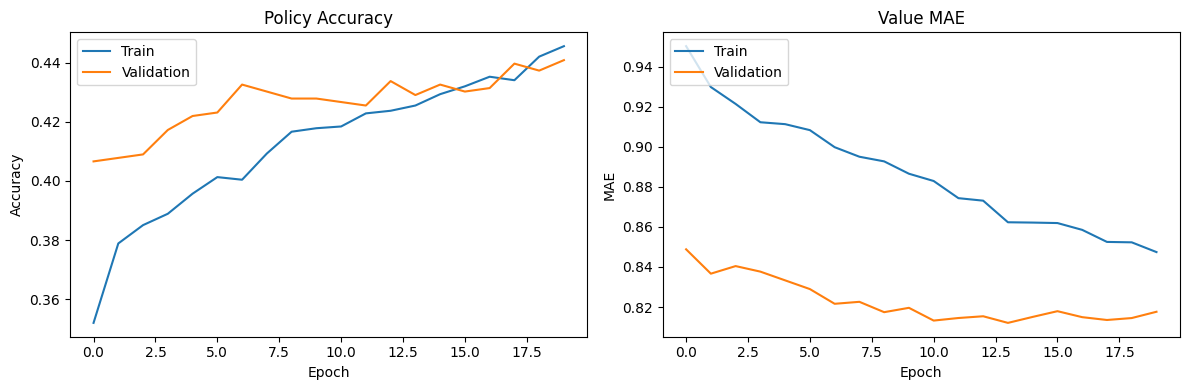

Chu kỳ 3 hoàn thành trong 159.40 phút


In [63]:
nn, history = train_model_cycle(cycles=3, games_per_cycle=50, epochs_per_cycle=20, mcts_simulations=2000)
agent = Connect4Agent(nn)

In [ ]:
nn = Connect4NeuralNetwork('models/connect4_model.h5')
agent = Connect4Agent(nn)
results_vs_mcts = evaluate_model(agent, num_games=1, opponent='mcts')

In [ ]:
from ai_battle import main

nn = Connect4NeuralNetwork('models/connect4_model.h5')
agent = Connect4Agent(nn)
main(agent)

In [17]:
# import pickle

# with open('models/evaluation_results.pkl', 'wb') as f:
#     pickle.dump({'vs_mcts': results_vs_mcts}, f)

# with open('models/training_history.pkl', 'wb') as f:
#     pickle.dump(history, f)

# print("Quá trình huấn luyện hoàn thành và đã lưu kết quả!")

Quá trình huấn luyện hoàn thành và đã lưu kết quả!


In [44]:
# import shutil
# shutil.copy('models/connect4_model_cycle_1.h5', 'models/connect4_model_backup.h5')

'models/connect4_model_backup.h5'

In [113]:
# import shutil
# import os

# if os.path.exists('models/connect4_model_debug.h5'):
#     shutil.copy('models/connect4_model.h5', 'models/connect4_model_backup.h5')